In [30]:
import warnings
from pathlib import Path

import torch
from lavis.processors.blip_processors import BlipImageEvalProcessor
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from query_perturbation.data.box_loader import BoxInfo
from query_perturbation.models.blip2.blip2_qpert import BLIP2Extractor
from query_perturbation.models.weight import AreaBasedWeight, AreaWeightType

warnings.simplefilter("ignore")
CONF_ROOT_DIR = Path("/query-perturbation/examples/")

# config
config_path = CONF_ROOT_DIR / "blip2_flickr.yaml"

# image preprocessor
processor = BlipImageEvalProcessor(364)

# weight function for each projection
weight = AreaBasedWeight(6, 8, AreaWeightType.CONSTANT)

# for subspace dimension. 
# n_pc must be float value less than 1, or an int.
# if n_pc is a float, n_pc is used as a threshold for contribution ratio.
# if n_pc is an int, subspace dimension is set to n_pc.
n_pc = 0.9

# feature extractor
extractor = BLIP2Extractor(config_path, n_pc, "cuda", weight)


Position interpolate from 16x16 to 26x26


Load image and show a bounding box

[xmin, ymin, xmax, ymax] =  [20, 150, 370, 220]


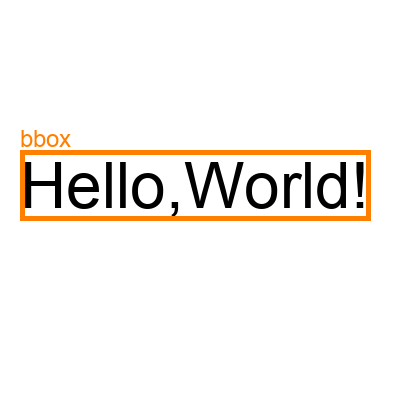

In [31]:
# xmin, ymin, xmax, ymax
bbox = [20, 150, 370, 220]

image = Image.open("hello_world.png")

font_color = (255, 128, 0)
dr = ImageDraw.Draw(image)
# bounding box
dr.rectangle(bbox, outline=font_color, width=5)
# text
font = ImageFont.truetype("arial.ttf", 24)
dr.text((20, 125), "bbox", font_color, font=font)

# bounding box info and image
print("[xmin, ymin, xmax, ymax] = ", bbox)
image

Feature extraction by Query Perturbation for a single image and a single bounding box.

In [32]:
width, height = image.width, image.height

# Organize bbox infomation
box_width = bbox[2] - bbox[0]
box_height = bbox[3] - bbox[1]
area = (box_width * box_height) / (width * height)
box_info = BoxInfo(
    areas=[area],
    boxes=[bbox],
    img_size=[height, width],
    sentences=["hello world"]
)


img_tensor = processor(image).cuda().unsqueeze(0)
with torch.inference_mode():
    qpert_feats = extractor.extract_vis_feats(img_tensor, [box_info])
    blip_feats = extractor.extract_vis_feats(img_tensor, None)

print(qpert_feats.shape)
# 32 is the BLIP-2s' hyperparameter, i.e, #learned queries.

sim = qpert_feats @ blip_feats.transpose(1, 2)
print(sim)


torch.Size([1, 32, 256])
tensor([[[0.9809, 0.7478, 0.8728,  ..., 0.9634, 0.8322, 0.8527],
         [0.7839, 0.9774, 0.8148,  ..., 0.7879, 0.6763, 0.8324],
         [0.8645, 0.8022, 0.9818,  ..., 0.8350, 0.8516, 0.7955],
         ...,
         [0.9871, 0.7507, 0.8298,  ..., 0.9922, 0.8071, 0.8504],
         [0.8032, 0.6321, 0.8280,  ..., 0.7926, 0.9929, 0.7751],
         [0.8531, 0.7790, 0.7625,  ..., 0.8581, 0.7813, 0.9890]]],
       device='cuda:0')


Feature extraction by Query Perturbation for M images and N bounding boxes.

In [33]:
width, height = image.width, image.height

# Organize bbox infomation
box_width = bbox[2] - bbox[0]
box_height = bbox[3] - bbox[1]
area = (box_width * box_height) / (width * height)

# n bounding boxes for an image
n = 2
box_info = BoxInfo(
    areas=[area] * n,
    boxes=[bbox] * n,
    img_size=[height, width],
    sentences=["hello world"]
)

# m images
m = 4
img_tensor = processor(image).cuda().unsqueeze(0)
img_tensors = torch.cat([img_tensor] * m, 0)

box_infos = [box_info] * m

with torch.inference_mode():
    qpert_feats = extractor.extract_vis_feats(img_tensors, box_infos)

print(qpert_feats.shape)
# 32 is the BLIP-2s' hyperparameter, i.e, #learned queries.

torch.Size([4, 32, 256])
